In [0]:
%matplotlib inline
from matplotlib import style
from matplotlib import dates
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [0]:
import numpy as np
import pandas as pd

In [0]:
import datetime as dt

In [4]:
!pip install sqlalchemy

    100% |████████████████████████████████| 5.6MB 5.7MB/s 
  Running setup.py bdist_wheel for sqlalchemy ... - \ | / - \ | / done
  Stored in directory: /root/.cache/pip/wheels/ed/bd/2e/d3874a6e97b8cc71e7e177c8d065ead30f67f380c4d9bbadaa
Successfully built sqlalchemy


# Reflect Tables into SQLAlchemy ORM

In [0]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [0]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [0]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [0]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [0]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


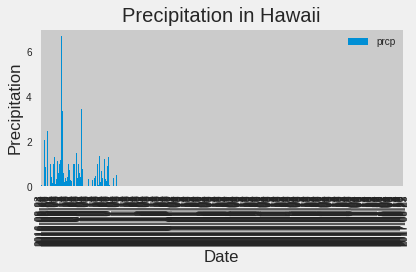

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
inspector = inspect(engine)

columns = inspector.get_columns('measurement')
for c in columns:
  print (c["name"], c["type"]) 
  
# Calculate the date 1 year ago from today
d1 = dt.date(2017,8,23)
yr_ago = d1- dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= yr_ago, Measurement.date <= d1).group_by(Measurement.date)

# Save the query results as a Pandas DataFrame and set the index to the date column
date = [result for result in results]
q1_df = pd.DataFrame(date)
q1_df.set_index('date', inplace=True, )

# Sort the dataframe by date
q1_df.sort_index(ascending=False)

# Use Pandas Plotting with Matplotlib to plot the data
q1_df.plot(kind = 'bar', title = 'Precipitation in Hawaii', rot = 90)
plt.ylabel('Precipitation')
plt.xlabel('Date')
plt.tight_layout()

# Rotate the xticks for the dates


In [12]:
yr_ago

datetime.date(2016, 8, 23)

![precipitation](Images/precipitation.png)

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
q1_df.describe()

,prcp
count,345.000000
mean,0.432087
std,0.704363
min,0.000000
25%,0.010000
50%,0.140000
75%,0.580000
max,6.700000


In [14]:
# How many stations are available in this dataset?
columns = inspector.get_columns('station')
for c in columns:
  print (c["name"], c["type"])

n_station = session.query(Station.id).count()
print(f'There are {n_station} stations in this dataset')

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
There are 9 stations in this dataset


In [15]:
# What are the most active stations?
active = session.query(Station.name, func.count(Measurement.id)).filter(Measurement.station == Station.station).\
group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
 
# List the stations and the counts in descending order.
a= [site for site in active]
a

[('WAIHEE 837.5, HI US', 2772),
 ('WAIKIKI 717.2, HI US', 2724),
 ('KANEOHE 838.1, HI US', 2709),
 ('WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('MANOA LYON ARBO 785.2, HI US', 2612),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('PEARL CITY, HI US', 1372),
 ('UPPER WAHIAWA 874.3, HI US', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
low = session.query(Station.name, Measurement.tobs).filter(Measurement.id == Station.id).\
group_by(Measurement.id).order_by(func.min(Measurement.tobs)).first()

high = session.query(Station.name, Measurement.tobs).filter(Measurement.id == Station.id).\
group_by(Measurement.id).order_by(func.max(Measurement.tobs).desc()).first()

avg =  session.query(Station.name, func.avg(Measurement.tobs)).filter(Station.name == 'WAIHEE 837.5, HI US').first()


print(low)
print(high)
print(avg)

('KANEOHE 838.1, HI US', 63.0)
('PEARL CITY, HI US', 76.0)
('WAIHEE 837.5, HI US', 73.09795396419437)


Text(0.5,0,'Temperature')

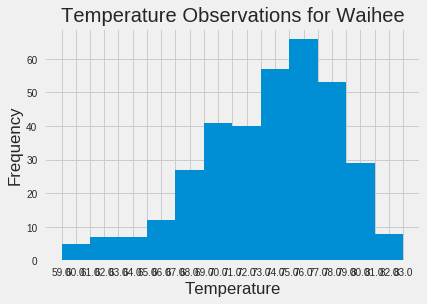

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
waihee_tobs = session.query(Measurement.tobs).\
filter(Station.name == "WAIHEE 837.5, HI US", Measurement.station == Station.station, Measurement.date >= yr_ago, Measurement.date <= d1)

temps = [t for t in waihee_tobs]
temps_df = pd.DataFrame(temps)
temps_df

plt.hist(temps_df, bins=12)
plt.title("Temperature Observations for Waihee")
plt.ylabel('Frequency')
plt.xlabel('Temperature')

In [18]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [35]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
ct = list(np.ravel(calc_temps("2017-01-25", "2017-02-15")))
ct

[59.0, 69.56643356643356, 80.0]

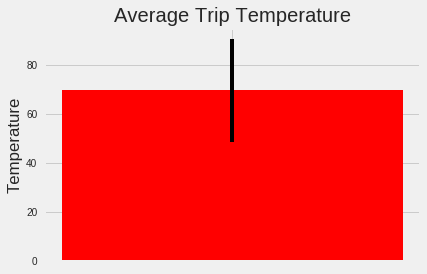

In [38]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.bar(1, ct[1], yerr=(ct[2] - ct[0]), tick_label='', color='red')
plt.ylabel("Temperature")
plt.title("Average Trip Temperature")
plt.show()

In [45]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

precep = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
filter(Measurement.id == Station.id).group_by(Station.station).order_by(func.sum(Measurement.prcp)).all()

precep

[('USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  21.4992,
  -158.0111,
  306.6,
  None),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  0.0),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.0),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.0),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.0),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.06),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.08)]

## Optional Challenge Assignment

In [16]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [0]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [0]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [0]:
# Plot the daily normals as an area plot with `stacked=False`
